# Milestone 1 Notebook

*Note: Steps 1 (team work contract) and 2 (creating repository) for this milestone are not included in this notebook.*

## Imports

In [1]:
import re
import os
import glob
import zipfile
import requests
from urllib.request import urlretrieve
import json
import pandas as pd
import pyarrow.dataset as ds
import pyarrow as pa
import pyarrow 
from pyarrow import csv
import rpy2_arrow.pyarrow_rarrow as pyra

## 3. Downloading the data

### Download using figshare's API

In this section we will use figshare's API to download the data from [this article](https://figshare.com/articles/dataset/Daily_rainfall_over_NSW_Australia/14096681).

In [2]:
# figshare article metadata
article_id = 14096681
url = f"https://api.figshare.com/v2/articles/{article_id}"
headers = {"Content-Type": "application/json"}

# directories for output
output_directory = "figsharerain/"
output_directory_files = "figsharerain/data/"

# get the files from figshare
response = requests.request("GET", url, headers=headers)
data = json.loads(response.text)
files = data["files"]

files

[{'id': 26579150,
  'name': 'daily_rainfall_2014.png',
  'size': 58863,
  'is_link_only': False,
  'download_url': 'https://ndownloader.figshare.com/files/26579150',
  'supplied_md5': 'fd32a2ffde300a31f8d63b1825d47e5e',
  'computed_md5': 'fd32a2ffde300a31f8d63b1825d47e5e'},
 {'id': 26579171,
  'name': 'environment.yml',
  'size': 192,
  'is_link_only': False,
  'download_url': 'https://ndownloader.figshare.com/files/26579171',
  'supplied_md5': '060b2020017eed93a1ee7dd8c65b2f34',
  'computed_md5': '060b2020017eed93a1ee7dd8c65b2f34'},
 {'id': 26586554,
  'name': 'README.md',
  'size': 5422,
  'is_link_only': False,
  'download_url': 'https://ndownloader.figshare.com/files/26586554',
  'supplied_md5': '61858c6cc0e6a6d6663a7e4c75bbd88c',
  'computed_md5': '61858c6cc0e6a6d6663a7e4c75bbd88c'},
 {'id': 26766812,
  'name': 'data.zip',
  'size': 814041183,
  'is_link_only': False,
  'download_url': 'https://ndownloader.figshare.com/files/26766812',
  'supplied_md5': 'b517383f76e77bd03755a63a8f

In [3]:
%%time

files_to_dl = ['data.zip']

# download files, this takes some time
for file in files:
    if file["name"] in files_to_dl:
        os.makedirs(output_directory, exist_ok=True)
        urlretrieve(file["download_url"], output_directory + file["name"])

CPU times: user 3.8 s, sys: 5.69 s, total: 9.49 s
Wall time: 1min 40s


### Extract file programmatically

In this section we extract the downloaded zip file programmatically, using base python.

In [4]:
%%time

# extract files
os.makedirs(output_directory_files, exist_ok=True)
with zipfile.ZipFile(os.path.join(output_directory, "data.zip"), 'r') as f:
    f.extractall(output_directory_files)

CPU times: user 25.8 s, sys: 5.29 s, total: 31.1 s
Wall time: 38.2 s


# 4. Combine data CSVs with Pandas

### Combine CSVs and add "model" column

In this section we combine the extracted CSVs with `pandas`.  In addition, we perform some data wrangling in order to add a `model` column to our combined DataFrame.

In [5]:
%%time

# files to combine
files = glob.glob('figsharerain/data/*.csv')
files.remove('figsharerain/data/observed_daily_rainfall_SYD.csv')

# combine with pandas
df = pd.concat(
    (
        pd.read_csv(file, index_col=0)
        .assign(model=re.findall(r'^[^_]*', file)[0]) for file in files) # model column
    )

# wrangle model column to only include name
df["model"] = df["model"].apply(lambda x: x.split("/")[-1])

# save combined file
df.to_csv("figsharerain/data/combined_data.csv")

CPU times: user 9min 31s, sys: 49.7 s, total: 10min 21s
Wall time: 11min


In [6]:
df.head()

,lat_min,lat_max,lon_min,lon_max,rain (mm/day),model
time,,,,,,
1889-01-01 12:00:00,-35.439867,-33.574619,141.5625,143.4375,4.244226e-13,MPI-ESM-1-2-HAM
1889-01-02 12:00:00,-35.439867,-33.574619,141.5625,143.4375,4.217326e-13,MPI-ESM-1-2-HAM
1889-01-03 12:00:00,-35.439867,-33.574619,141.5625,143.4375,4.498125e-13,MPI-ESM-1-2-HAM
1889-01-04 12:00:00,-35.439867,-33.574619,141.5625,143.4375,4.251282e-13,MPI-ESM-1-2-HAM
1889-01-05 12:00:00,-35.439867,-33.574619,141.5625,143.4375,4.270161e-13,MPI-ESM-1-2-HAM


In [7]:
print(df.shape)

(62467843, 6)


| Team Member | Operating System | RAM | Processor | Is SSD | Time taken |
|:-----------:|:----------------:|:---:|:---------:|:------:|:----------:|
| Nico        | Mac              |32gb | Intel i9  |  Yes   |  7min 11 sec          |
| Kristin    |  Mac                | 8gb    |  Intel i5         |   Yes     |   9min 8 sec         |
| Jennifer    | Mac             | 8gb  | Intel i5       |   Yes     |     9min 10s     |
| Morgan    |                  |     |           |        |            |

# 5. Load the combined CSV and perform EDA

Firstly, we'll check to see if we can load the entire dataset.

In [8]:
%%time
df = pd.read_csv("figsharerain/data/combined_data.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62467843 entries, 0 to 62467842
Data columns (total 7 columns):
 #   Column         Dtype  
---  ------         -----  
 0   time           object 
 1   lat_min        float64
 2   lat_max        float64
 3   lon_min        float64
 4   lon_max        float64
 5   rain (mm/day)  float64
 6   model          object 
dtypes: float64(5), object(2)
memory usage: 3.3+ GB
CPU times: user 1min 24s, sys: 30.1 s, total: 1min 54s
Wall time: 2min 37s


| Team Member | Operating System | RAM | Processor | Is SSD | Time taken |
|:-----------:|:----------------:|:---:|:---------:|:------:|:----------:|
| Nico        | Mac              |32gb | Intel i9  |  Yes   |            |
| Kristin    |  Mac                | 8gb    |  Intel i5         |   Yes     | 1min 45s            |
| Jennifer    | Mac             | 8gb  | Intel i5       |   Yes     |     1min 57s     |
| Morgan    |                  |     |           |        |            |

We were able to load the entire dataset, although this was fairly slow.

One approach to make the data more manageable is to reduce the memory requirement by reducing the precision of the numerical columns from float64 to float32.

In [9]:
%%time
df_float32 = pd.read_csv("figsharerain/data/combined_data.csv", dtype={'lat_min': 'float32', 'lat_max': 'float32', 'lon_min': 'float32', 'lon_max': 'float32', 'rain (mm/day)': 'float32'})
df_float32.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62467843 entries, 0 to 62467842
Data columns (total 7 columns):
 #   Column         Dtype  
---  ------         -----  
 0   time           object 
 1   lat_min        float32
 2   lat_max        float32
 3   lon_min        float32
 4   lon_max        float32
 5   rain (mm/day)  float32
 6   model          object 
dtypes: float32(5), object(2)
memory usage: 2.1+ GB
CPU times: user 1min 15s, sys: 19.1 s, total: 1min 34s
Wall time: 1min 49s


| Team Member | Operating System | RAM | Processor | Is SSD | Time taken |
|:-----------:|:----------------:|:---:|:---------:|:------:|:----------:|
| Nico        | Mac              |32gb | Intel i9  |  Yes   |            |
| Kristin    |  Mac                | 8gb    |  Intel i5         |   Yes     |  1min 49s          |
| Jennifer    | Mac             | 8gb  | Intel i5       |   Yes     |     1min 34s     |
| Morgan    |                  |     |           |        |            |

Changing the data type reduced the size of the data from 3.3+ GB to 2.1+ GB, but had a small impact on the data loading time.

Next, let's check the number of observations per model. We can try loading only the "model" column to further reduce memory usage.

In [10]:
%%time
use_cols = ['model']
model = pd.read_csv("figsharerain/data/combined_data.csv",usecols=use_cols)
print(model.value_counts())

model           
MPI-ESM1-2-HR       5154240
TaiESM1             3541230
NorESM2-MM          3541230
CMCC-CM2-HR4        3541230
CMCC-CM2-SR5        3541230
CMCC-ESM2           3541230
SAM0-UNICON         3541153
FGOALS-f3-L         3219300
GFDL-CM4            3219300
GFDL-ESM4           3219300
EC-Earth3-Veg-LR    3037320
MRI-ESM2-0          3037320
BCC-CSM2-MR         3035340
MIROC6              2070900
ACCESS-CM2          1932840
ACCESS-ESM1-5       1610700
INM-CM5-0           1609650
INM-CM4-8           1609650
KIOST-ESM           1287720
FGOALS-g3           1287720
MPI-ESM1-2-LR        966420
NESM3                966420
AWI-ESM-1-1-LR       966420
MPI-ESM-1-2-HAM      966420
NorESM2-LM           919800
BCC-ESM1             551880
CanESM5              551880
dtype: int64
CPU times: user 41.4 s, sys: 5.86 s, total: 47.2 s
Wall time: 51.9 s


| Team Member | Operating System | RAM | Processor | Is SSD | Time taken |
|:-----------:|:----------------:|:---:|:---------:|:------:|:----------:|
| Nico        | Mac              |32gb | Intel i9  |  Yes   |            |
| Kristin    |  Mac                | 8gb    |  Intel i5         |   Yes     |  44s          |
| Jennifer    | Mac             | 8GB  | Intel i5       |   Yes     |     43s     |
| Morgan    |                  |     |           |        |            |

Loading and summarizing a single column with `value_counts` was a fairly quick operation and took less than half the time compared to loading in the entire dataframe, although this might not be an efficient approach for performing EDA on all columns in the data.

We'll summarize all the numeric columns from the original combined dataframe below:

In [11]:
%%time
df.describe()

CPU times: user 14.8 s, sys: 10 s, total: 24.8 s
Wall time: 30.6 s


,lat_min,lat_max,lon_min,lon_max,rain (mm/day)
count,5.924854e+07,6.246784e+07,5.924854e+07,6.246784e+07,5.924854e+07
mean,-3.310482e+01,-3.197757e+01,1.469059e+02,1.482150e+02,1.901170e+00
std,1.963549e+00,1.992067e+00,3.793784e+00,3.809994e+00,5.585735e+00
min,-3.646739e+01,-3.600000e+01,1.406250e+02,1.412500e+02,-3.807373e-12
25%,-3.486911e+01,-3.366221e+01,1.434375e+02,1.450000e+02,3.838413e-06
50%,-3.300000e+01,-3.204188e+01,1.468750e+02,1.481250e+02,6.154947e-02
75%,-3.140170e+01,-3.015707e+01,1.501875e+02,1.513125e+02,1.020918e+00
max,-2.990000e+01,-2.790606e+01,1.537500e+02,1.556250e+02,4.329395e+02


| Team Member | Operating System | RAM | Processor | Is SSD | Time taken |
|:-----------:|:----------------:|:---:|:---------:|:------:|:----------:|
| Nico        | Mac              |32gb | Intel i9  |  Yes   |            |
| Kristin    |  Mac                | 8gb    |  Intel i5         |   Yes     |   22s         |
| Jennifer    | Mac             | 8GB  | Intel i5       |   Yes     |     29s     |
| Morgan    |                  |     |           |        |            |

*Summary of observations of runtimes*



# 6. Perform EDA in R

In [12]:
%load_ext rpy2.ipython

Next we will transfer the dataframe from python to R using Pandas exchange as a baseline for comparison and Arrow exchange as the more efficient solution. An attempt to use Pandas exchange to load the entire dataset and to transfer to R was made, however the kernel kept dying, and it could not be done so we performed this operation on a reduced data set of 10,000,000 rows below. For simplicity, we will continue to explore the count of the 'model' column rather than summarizing the entire dataset.

In [13]:
df_reduced = pd.read_csv("figsharerain/data/combined_data.csv", nrows=10000000)

In [14]:
%%time
%%R -i df_reduced
start_time <- Sys.time()
suppressMessages(library(dplyr))
result <- df_reduced %>% count(model)
print(result)
end_time <- Sys.time()
print(end_time - start_time)

            model       n
1      ACCESS-CM2 1932840
2  AWI-ESM-1-1-LR  966420
3    CMCC-CM2-HR4 1995220
4     FGOALS-f3-L 3219300
5 MPI-ESM-1-2-HAM  966420
6      NorESM2-LM  919800
Time difference of 1.994107 secs
CPU times: user 6min 43s, sys: 17 s, total: 7min
Wall time: 7min 20s


| Team Member | Operating System | RAM | Processor | Is SSD | Time taken |
|:-----------:|:----------------:|:---:|:---------:|:------:|:----------:|
| Nico        | Mac              |32gb | Intel i9  |  Yes   |            |
| Kristin    |  Mac                | 8gb    |  Intel i5         |   Yes     |   6min 32s         |
| Jennifer    | Mac             | 8GB  | Intel i5       |   Yes     |          |
| Morgan    |                  |     |           |        |            |

Even with the reduced dataset, this form of transferring from python to R took quite a long time. Next we will transfer the dataframe using Arrow exchange and compare the results. The below code is adapted from Lecture 2.

In [15]:
%%time
dataset = ds.dataset("figsharerain/data/combined_data.csv", format="csv")
table = dataset.to_table()
r_table = pyra.converter.py2rpy(table)

CPU times: user 1min 8s, sys: 9.01 s, total: 1min 17s
Wall time: 1min 24s


In [16]:
%%time
%%R -i r_table
start_time <- Sys.time()
suppressMessages(library(dplyr))
result <- r_table %>% count(model)
end_time <- Sys.time()
print(result %>% collect())
print(end_time - start_time)

# A tibble: 27 × 2
   model                  n
   <chr>              <int>
 1 MPI-ESM-1-2-HAM   966420
 2 AWI-ESM-1-1-LR    966420
 3 NorESM2-LM        919800
 4 ACCESS-CM2       1932840
 5 FGOALS-f3-L      3219300
 6 CMCC-CM2-HR4     3541230
 7 MRI-ESM2-0       3037320
 8 GFDL-CM4         3219300
 9 BCC-CSM2-MR      3035340
10 EC-Earth3-Veg-LR 3037320
# … with 17 more rows
Time difference of 0.04350209 secs
CPU times: user 4.04 s, sys: 2.04 s, total: 6.08 s
Wall time: 2.8 s


| Team Member | Operating System | RAM | Processor | Is SSD | Time taken |
|:-----------:|:----------------:|:---:|:---------:|:------:|:----------:|
| Nico        | Mac              |32gb | Intel i9  |  Yes   |            |
| Kristin    |  Mac                | 8gb    |  Intel i5         |   Yes     |   6.5s         |
| Jennifer    | Mac             | 8GB  | Intel i5       |   Yes     |          |
| Morgan    |                  |     |           |        |            |

Clearly using Arrow exchange proved to be much faster and more efficient. This is due to Arrow reading and processing data in chunks and in parallel, it's columnar memory format, zero-copy reads, and most importantly it's minimal serialization, which accounts for the vast majority of the improvement from Pandas exchange.

We chose to use Arrow here as it is widely recognized for it's ability to exchange large sums of data with with low overhead, and it's broad flexibility that can support most complex data science models and dynamic datasets. As we do not yet know what is coming down the pipeline in Milestone 2, we feel that arrow is a robust bet. Also, as this is a group project and we all have different computers, Arrows language-independence means that it can be implemented by any computer program that processes memory data which is another one of it's benefits. [reference](https://www.heavy.ai/technical-glossary/apache-arrow#:~:text=Apache%20Arrow%20impxdoves%20the%20speed,also%20provides%20libraries%20for%20software.

In [17]:
%%R
suppressMessages(library(arrow, warn.conflicts = FALSE))
suppressMessages(library(dplyr, warn.conflicts = FALSE))
suppressMessages(library(tidyverse, warn.conflicts = FALSE))

Some EDA using R, summarizing the mean of lat_max by model:

In [19]:
%%R -i r_table
result <- r_table %>% group_by(model) %>%
    summarise(mean = mean(lat_max), n = n())
print(result %>% collect())

# A tibble: 27 × 3
   model             mean       n
   <chr>            <dbl>   <int>
 1 MPI-ESM-1-2-HAM  -31.7  966420
 2 AWI-ESM-1-1-LR   -31.7  966420
 3 NorESM2-LM       -31.3  919800
 4 ACCESS-CM2       -31.9 1932840
 5 FGOALS-f3-L      -32.1 3219300
 6 CMCC-CM2-HR4     -32.0 3541230
 7 MRI-ESM2-0       -32.0 3037320
 8 GFDL-CM4         -32   3219300
 9 BCC-CSM2-MR      -32.0 3035340
10 EC-Earth3-Veg-LR -32.0 3037320
# … with 17 more rows
Time difference of 0.0639801 secs
CPU times: user 4.55 s, sys: 2.3 s, total: 6.85 s
Wall time: 3.71 s


Arrow would not communicate with tidyverse, so we were unable to use ggplot. Instead we opted to use a reduced pandas exchange method, only the column "model", to make a bar chart:

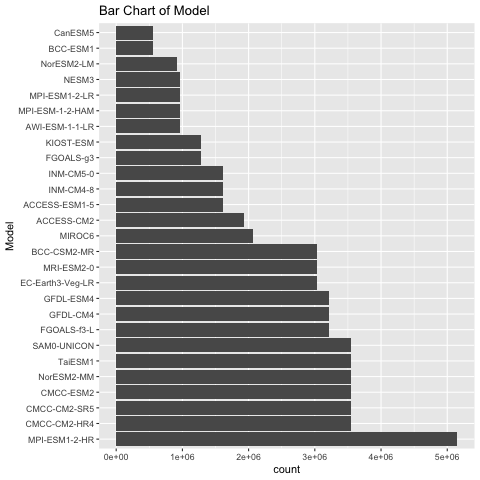

In [27]:
%%R -i model
result <- model %>% 
    add_count(model) %>%
    ggplot(aes(y = reorder(model, -n))) +
        geom_bar(stat = 'count') +
        labs(y = 'Model') +
        ggtitle('Bar Chart of Model')
print(result)